In [139]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [140]:
data_dir = "./exp-local/data"


def import_data(dir):
    all_files = Path(dir).glob('data*.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
data

,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,...,WCKey,WCKeyID,WorkDir,Submit,Unnamed: 112,Unnamed: 113,SubmitLine,Unnamed: 114,Unnamed: 110,Unnamed: 111
0,49263,daa-local-nc4_gl5-28.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:19:37,2024-01-19T12:19:37,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=daa-local-nc4_gl5-28.cfg -w ...,&& haddock3 'daa-local-nc4_gl5-28.cfg',> run.daa-local-nc4_gl5-28.cfg.info/haddock.ou...,NaN,NaN,NaN
1,49263.batch,batch,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:19:37,2024-01-19T12:19:37,10,876K,...,NaN,NaN,NaN,2024-01-19T12:19:37,NaN,NaN,NaN,NaN,NaN,NaN
2,49266,daa-local-nc4_gl5-24.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:24:44,2024-01-19T12:24:44,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=daa-local-nc4_gl5-24.cfg -w ...,&& haddock3 'daa-local-nc4_gl5-24.cfg',> run.daa-local-nc4_gl5-24.cfg.info/haddock.ou...,NaN,NaN,NaN
3,49266.batch,batch,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:24:44,2024-01-19T12:24:44,13,880K,...,NaN,NaN,NaN,2024-01-19T12:24:44,NaN,NaN,NaN,NaN,NaN,NaN
4,49269,dpp-local-nc4_gl5-22.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:29:50,2024-01-19T12:29:51,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=dpp-local-nc4_gl5-22.cfg -w ...,&& haddock3 'dpp-local-nc4_gl5-22.cfg',> run.dpp-local-nc4_gl5-22.cfg.info/haddock.ou...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,49668,daa-local-nc4_ss2-3.cfg,gl2_gl4,NaN,None assigned,PENDING,Unknown,Unknown,0.0,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,"-e power/energy-pkg/,power/energy-ram/ haddock...",NaN,> run.daa-local-nc4_ss2-3.cfg.info/haddock.out...,NaN,sbatch --job-name=daa-local-nc4_ss2-3.cfg -w s...,&& perf stat
303,49671,daa-local-nc4_ss2-5.cfg,gl2_gl4,NaN,None assigned,PENDING,Unknown,Unknown,0.0,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,"-e power/energy-pkg/,power/energy-ram/ haddock...",NaN,> run.daa-local-nc4_ss2-5.cfg.info/haddock.out...,NaN,sbatch --job-name=daa-local-nc4_ss2-5.cfg -w s...,&& perf stat
304,49674,dpp-local-nc16_ss2-5.cfg,gl2_gl4,NaN,None assigned,PENDING,Unknown,Unknown,0.0,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,"power/energy-pkg/,power/energy-ram/ haddock3 '...",NaN,run.dpp-local-nc16_ss2-5.cfg.info/haddock.outp...,NaN,sbatch --job-name=dpp-local-nc16_ss2-5.cfg -w ...,perf stat -e
305,49677,dpp-local-nc4_ss2-6.cfg,gl2_gl4,NaN,None assigned,PENDING,Unknown,Unknown,0.0,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,"-e power/energy-pkg/,power/energy-ram/ haddock...",NaN,> run.dpp-local-nc4_ss2-6.cfg.info/haddock.out...,NaN,sbatch --job-name=dpp-local-nc4_ss2-6.cfg -w s...,&& perf stat


In [141]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [142]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(\w+?\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [143]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_34788\1217720985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
6,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,88.35429,12747730.0,12747.73,12.74773,27547032.0,27547.032,27.547032,65071,1084.516667,18.075278
8,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,88.35445,12748270.0,12748.27,12.74827,27545968.0,27545.968,27.545968,64602,1076.700000,17.945000
11,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,88.35671,12752490.0,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222
12,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,88.37871,12753280.0,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667
28,48972.batch,daa-local-nc4_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:55:38,2024-01-20T00:06:09,7540000.0,1.468972e+09,8.835445e+10,...,88.35445,12749260.0,12749.26,12.74926,27545096.0,27545.096,27.545096,61831,1030.516667,17.175278
34,48993.batch,daa-local-nc4_gl6-36.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:39:24,2024-01-21T14:04:20,7630000.0,1.487932e+09,8.837870e+10,...,88.37870,12752500.0,12752.50,12.75250,27542816.0,27542.816,27.542816,62696,1044.933333,17.415556
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444200.0,6.570280e+08,5.345290e+09,...,5.34529,805040.0,805.04,0.80504,26432932.0,26432.932,26.432932,4478,74.633333,1.243889
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449460.0,6.930640e+08,5.345290e+09,...,5.34529,805040.0,805.04,0.80504,26526812.0,26526.812,26.526812,4564,76.066667,1.267778
10,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,5.34347,805040.0,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611
36,49005.batch,dpp-local-nc4_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-21T15:07:50,2024-01-21T16:20:28,514220.0,6.730080e+08,5.342040e+09,...,5.34204,804960.0,804.96,0.80496,26462072.0,26462.072,26.462072,4358,72.633333,1.210556


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49431,daa-local-nc4_gl5-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc4_gl5-38.cfg.info/haddock.ou...,daa,local,4,gl5,38
1,49434,daa-local-nc8_gl5-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc8_gl5-33.cfg.info/haddock.ou...,daa,local,8,gl5,33
2,49437,dpp-local-nc4_gl5-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.dpp-local-nc4_gl5-31.cfg.info/haddock.ou...,dpp,local,4,gl5,31
3,49440,dpp-local-nc8_gl5-39.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.dpp-local-nc8_gl5-39.cfg.info/haddock.ou...,dpp,local,8,gl5,39
4,49443,dpp-local-nc16_gl5-34.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,run.dpp-local-nc16_gl5-34.cfg.info/haddock.out...,dpp,local,16,gl5,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,49668,daa-local-nc4_ss2-3.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.daa-local-nc4_ss2-3.cfg.info/haddock.out...,daa,local,4,ss2,3
111,49671,daa-local-nc4_ss2-5.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.daa-local-nc4_ss2-5.cfg.info/haddock.out...,daa,local,4,ss2,5
112,49674,dpp-local-nc16_ss2-5.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,run.dpp-local-nc16_ss2-5.cfg.info/haddock.outp...,dpp,local,16,ss2,5
113,49677,dpp-local-nc4_ss2-6.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.dpp-local-nc4_ss2-6.cfg.info/haddock.out...,dpp,local,4,ss2,6


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49272.batch,dpp-local-nc16_gl5-25.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T12:34:57,2024-01-19T13:01:53,197.35K,2205380K,5345.30M,...,NaN,NaN,NaN,2024-01-19T12:34:57,NaN,dpp,local,16,gl5,25
1,49275.batch,dpp-local-nc16_gl5-23.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:06:57,2024-01-19T13:33:40,196.53K,2206532K,5345.29M,...,NaN,NaN,NaN,2024-01-19T13:06:57,NaN,dpp,local,16,gl5,23
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444.20K,657028K,5345.29M,...,NaN,NaN,NaN,2024-01-19T13:38:44,NaN,dpp,local,4,gl5,21
3,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,NaN,NaN,NaN,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,NaN,NaN,NaN,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,49668,daa-local-nc4_ss2-3.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.daa-local-nc4_ss2-3.cfg.info/haddock.out...,daa,local,4,ss2,3
154,49671,daa-local-nc4_ss2-5.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.daa-local-nc4_ss2-5.cfg.info/haddock.out...,daa,local,4,ss2,5
155,49674,dpp-local-nc16_ss2-5.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,run.dpp-local-nc16_ss2-5.cfg.info/haddock.outp...,dpp,local,16,ss2,5
156,49677,dpp-local-nc4_ss2-6.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,> run.dpp-local-nc4_ss2-6.cfg.info/haddock.out...,dpp,local,4,ss2,6


In [144]:
data = data.dropna(subset=['AveCPU'])

data['n_ave_cpu'] = data['AveCPU'].apply(convert_elapsed_time)
data['n_elapsed'] = data['Elapsed'].apply(convert_elapsed_time)
data['cpu_utilization'] = data['n_ave_cpu'] / data['n_elapsed']
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,Submit,SubmitLine,Workflow,mode,ncores,node,trial,n_ave_cpu,n_elapsed,cpu_utilization
0,49272.batch,dpp-local-nc16_gl5-25.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T12:34:57,2024-01-19T13:01:53,197.35K,2205380K,5345.30M,...,2024-01-19T12:34:57,NaN,dpp,local,16,gl5,25,19612,1616,12.136139
1,49275.batch,dpp-local-nc16_gl5-23.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:06:57,2024-01-19T13:33:40,196.53K,2206532K,5345.29M,...,2024-01-19T13:06:57,NaN,dpp,local,16,gl5,23,19588,1603,12.219588
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444.20K,657028K,5345.29M,...,2024-01-19T13:38:44,NaN,dpp,local,4,gl5,21,15786,4478,3.525234
3,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37,17247,2613,6.600459
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38,252844,36993,6.834915
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,2024-01-20T05:18:16,NaN,dpp,local,4,gl5,36,15875,4564,3.478309
6,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6.81M,1458672K,88354.29M,...,2024-01-20T06:39:24,NaN,daa,local,4,gl5,32,225582,65071,3.466706
7,49416.batch,dpp-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T00:48:59,2024-01-21T01:31:40,281.23K,1204728K,5345.28M,...,2024-01-21T00:48:59,NaN,dpp,local,8,gl5,38,17227,2561,6.726669
8,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6.77M,1480084K,88354.45M,...,2024-01-21T01:36:44,NaN,daa,local,4,gl5,35,224956,64602,3.482183
9,49422.batch,daa-local-nc8_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T19:38:30,2024-01-22T06:01:25,4.24M,2622720K,88378.71M,...,2024-01-21T19:38:30,NaN,daa,local,8,gl5,35,252969,37375,6.768401


In [145]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [146]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'new.local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                              \
                                        count          mean           std   
0       daa  local      4  gl5            2.0  6.790000e+06  28284.271247   
1       daa  local      4  gl6            4.0  7.585000e+06  36968.455021   
2       daa  local      8  gl5            2.0  4.220000e+06  28284.271247   
3       daa  local      8  gl6            4.0  4.750000e+06  14142.135624   
4       daa  local     16  gl6            1.0  3.260000e+06           NaN   
5       daa  local     32  gl6            4.0  2.710000e+06  20000.000000   
6       dpp  local      4  gl5            2.0  4.468300e+05   3719.381669   
7       dpp  local      4  gl6            4.0  5.156275e+05   2029.275322   
8       dpp  local      8  gl5            2.0  2.822650e+05   1463.711037   
9       dpp  local      8  gl6            4.0  3.244925e+05   4536.918007   
10      dpp  local     16  gl5            2.0  1.969400e+05    579.827561   
11      dpp  local     16  gl6            6.0  2.301450e+05    827.882842   
12      dpp  local     32  gl6            6.0  1.987117e+05   2693.491538   

                                     ... ElapsedMinutes               \
          min        25%        50%  ...            75%          max   
0   6770000.0  6780000.0  6790000.0  ...    1082.562500  1084.516667   
1   7540000.0  7570000.0  7585000.0  ...    1039.808333  1044.933333   
2   4200000.0  4210000.0  4220000.0  ...     621.325000   622.916667   
3   4730000.0  4745000.0  4755000.0  ...     593.400000   596.850000   
4   3260000.0  3260000.0  3260000.0  ...     369.333333   369.333333   
5   2700000.0  2700000.0  2700000.0  ...     280.008333   286.183333   
6    444200.0   445515.0   446830.0  ...      75.708333    76.066667   
7    513660.0   514080.0   515450.0  ...      73.183333    74.283333   
8    281230.0   281747.5   282265.0  ...      43.333333    43.550000   
9    318590.0   322287.5   325185.0  ...      42.791667    43.216667   
10   196530.0   196735.0   196940.0  ...      26.879167    26.933333   
11   229190.0   229475.0   230120.0  ...      26.783333    27.433333   
12   195380.0   197527.5   198015.0  ...      21.916667    23.616667   

   ElapsedHours                                                        \
          count       mean       std        min        25%        50%   
0           2.0  18.010139  0.092120  17.945000  17.977569  18.010139   
1           4.0  17.288681  0.099710  17.175278  17.240486  17.281944   
2           2.0  10.328889  0.075032  10.275833  10.302361  10.328889   
3           4.0   9.880764  0.047499   9.835000   9.861042   9.870278   
4           1.0   6.155556       NaN   6.155556   6.155556   6.155556   
5           4.0   4.657778  0.075381   4.606667   4.618333   4.627361   
6           2.0   1.255833  0.016892   1.243889   1.249861   1.255833   
7           4.0   1.218750  0.012935   1.210556   1.212222   1.213194   
8           2.0   0.718611  0.010214   0.711389   0.715000   0.718611   
9           4.0   0.700972  0.017607   0.682222   0.688472   0.700694   
10          2.0   0.447083  0.002553   0.445278   0.446181   0.447083   
11          6.0   0.445880  0.006003   0.440556   0.442292   0.444444   
12          6.0   0.361667  0.017098   0.349444   0.350903   0.354028   

                          
          75%        max  
0   18.042708  18.075278  
1   17.330139  17.415556  
2   10.355417  10.381944  
3    9.890000   9.947500  
4    6.155556   6.155556  
5    4.666806   4.769722  
6    1.261806   1.267778  
7    1.219722   1.238056  
8    0.722222   0.725833  
9    0.713194   0.720278  
10   0.447986   0.448889  
11   0.446389   0.457222  
12   0.365278   0.393611  

[13 rows x 500 columns]

In [147]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('new.local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl5,2,"[32, 35]"
1,daa,local,4,gl6,4,"[32, 33, 36, 40]"
2,daa,local,8,gl5,2,"[35, 38]"
3,daa,local,8,gl6,4,"[31, 32, 34, 38]"
4,daa,local,16,gl6,1,[33]
5,daa,local,32,gl6,4,"[35, 36, 38, 40]"
6,dpp,local,4,gl5,2,"[21, 36]"
7,dpp,local,4,gl6,4,"[35, 36, 38, 39]"
8,dpp,local,8,gl5,2,"[37, 38]"
9,dpp,local,8,gl6,4,"[31, 34, 35, 38]"


In [159]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores']).agg(
    n_trials=('trial', 'count')).reset_index()
collected_data.to_csv('new.total_local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,n_trials
0,daa,local,4,6
1,daa,local,8,6
2,daa,local,16,1
3,daa,local,32,4
4,dpp,local,4,6
5,dpp,local,8,6
6,dpp,local,16,8
7,dpp,local,32,6


In [148]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx, node):
    return f'[{to_local_config_class(x.Workflow, node if node else x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, data_of_node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == data_of_node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [149]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n, data_of_node):
    configs, warmup_config = get_configs_code_for_new_experiment(node, data_of_node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH + 1)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.config.Config import Config
from examples.domain.config.LocalConfig import LocalConfig

class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [150]:
# new experiment epochs
def generate_experiment_classes(exp_epochs, data_of_node: str):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH, data_of_node)
        if class_code is None:
            continue

        file_path = f"../examples/domain/experiment/local/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)

# generate_experiment_classes({
#     # "gl2": 3,
#     # "gl6": 3,
#     "gl5": 3
# }, data_of_node="gl6")

In [151]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
6,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,12747.73,12.74773,27547032.0,27547.032,27.547032,65071,1084.516667,18.075278,2,True
8,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,12748.27,12.74827,27545968.0,27545.968,27.545968,64602,1076.700000,17.945000,2,True
11,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222,4,True
12,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667,4,True
28,48972.batch,daa-local-nc4_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:55:38,2024-01-20T00:06:09,7540000.0,1.468972e+09,8.835445e+10,...,12749.26,12.74926,27545096.0,27545.096,27.545096,61831,1030.516667,17.175278,4,True
34,48993.batch,daa-local-nc4_gl6-36.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:39:24,2024-01-21T14:04:20,7630000.0,1.487932e+09,8.837870e+10,...,12752.50,12.75250,27542816.0,27542.816,27.542816,62696,1044.933333,17.415556,4,True
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444200.0,6.570280e+08,5.345290e+09,...,805.04,0.80504,26432932.0,26432.932,26.432932,4478,74.633333,1.243889,2,True
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449460.0,6.930640e+08,5.345290e+09,...,805.04,0.80504,26526812.0,26526.812,26.526812,4564,76.066667,1.267778,2,True
10,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611,4,True
36,49005.batch,dpp-local-nc4_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-21T15:07:50,2024-01-21T16:20:28,514220.0,6.730080e+08,5.342040e+09,...,804.96,0.80496,26462072.0,26462.072,26.462072,4358,72.633333,1.210556,4,True


In [152]:
import matplotlib.pyplot as plt

In [153]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

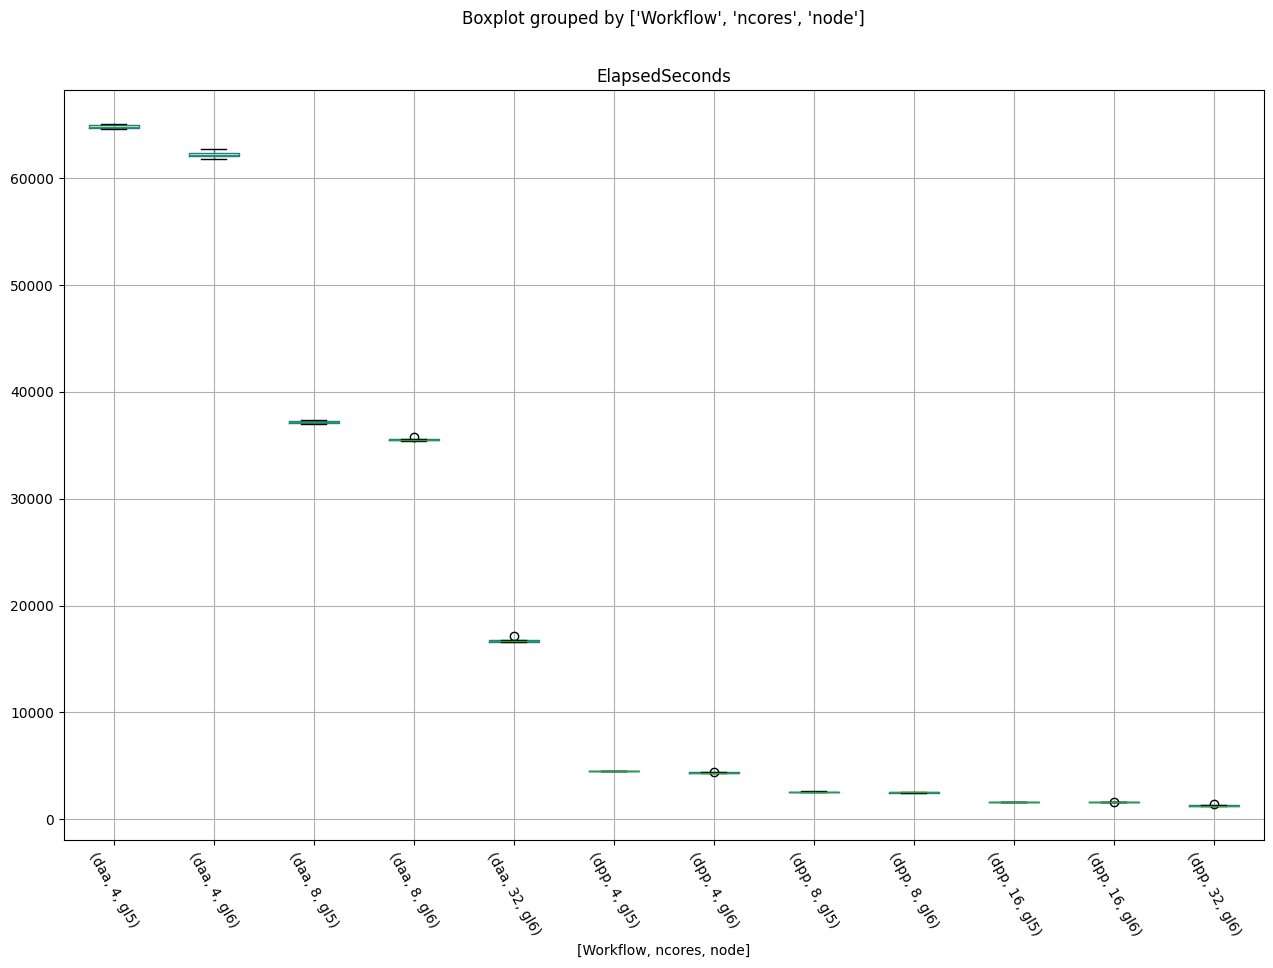

In [154]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('new.boxplot.png')


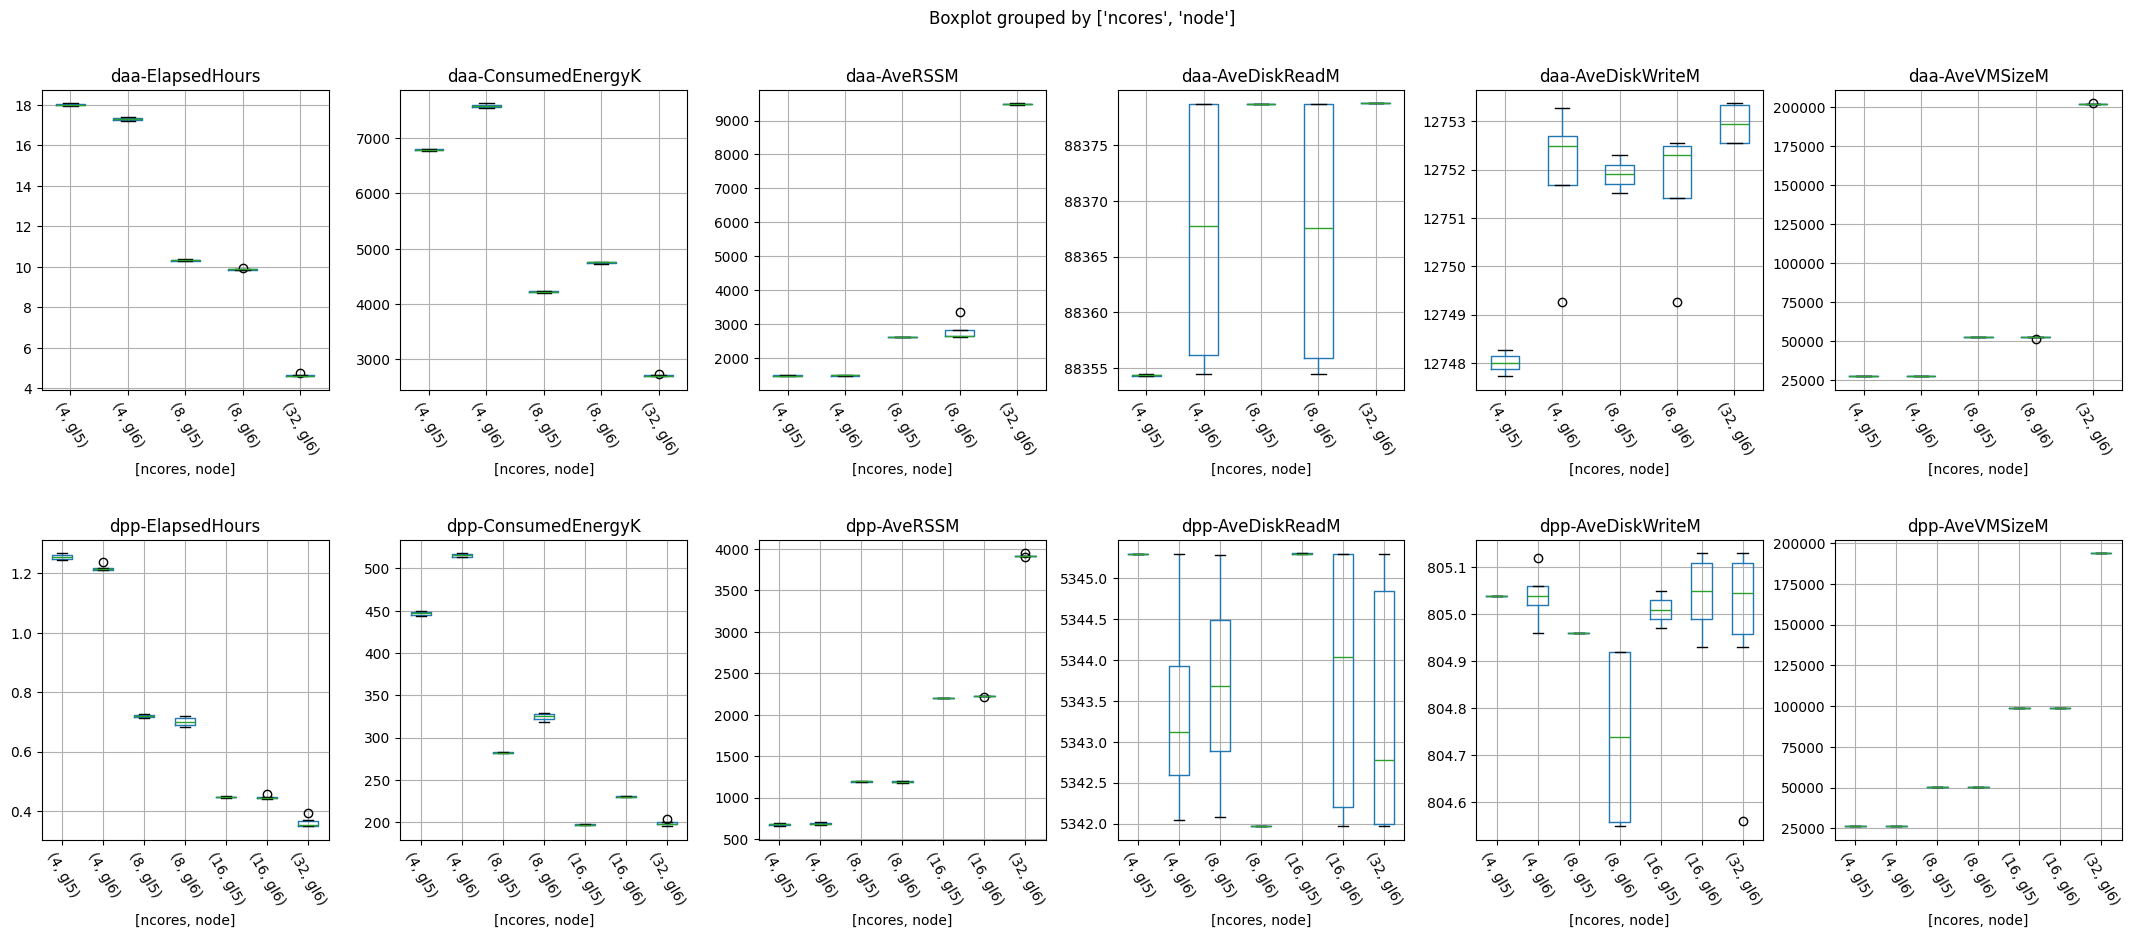

In [155]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('new.boxplot-overview-by-workflows.png')

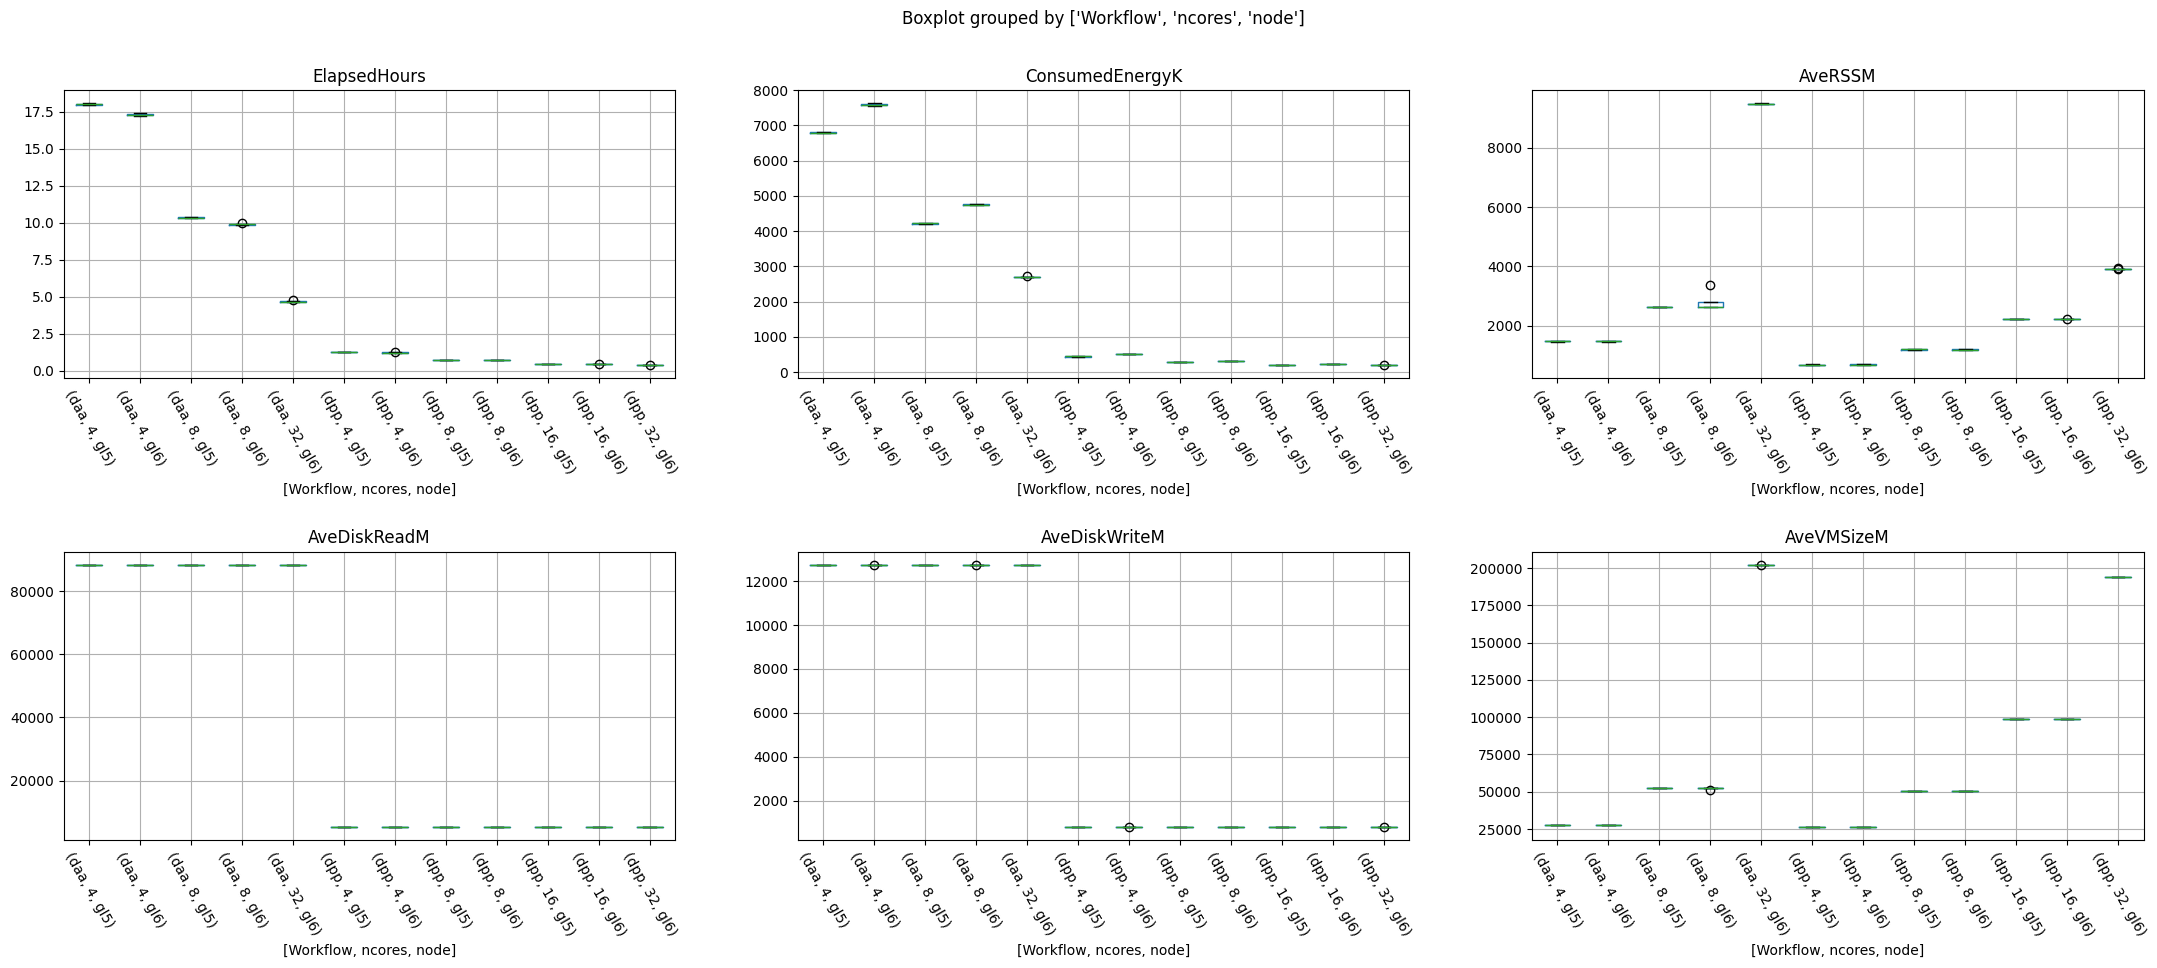

In [156]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('new.boxplot-overview.png')